### Imports

In [47]:
import sys
sys.path.append('../')

from math import degrees
from random import randint
from collections import Counter

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy.signal import find_peaks

from sklearn.cluster import KMeans

from skimage import filters
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny
from skimage.measure import regionprops
from skimage.segmentation import watershed, expand_labels
from skimage.transform import rotate, resize, probabilistic_hough_line
from skimage.filters import gaussian
from mycolorpy import colorlist as mcp

from resources.utils import *
from resources.metrics import *

colors = mcp.gen_color(cmap='Paired', n=10)
colors = [list(int(h.lstrip('#')[i:i+2], 16)/256 for i in (0, 2, 4)) for h in colors]

### Preprocessing

In [17]:
ms_path = '../data/DRON_Gilesky_2019-09-18/2Stack_Gilesky2_18-09-19_tif.tif'
rgb_path = '../data/DRON_Gilesky_2019-09-18/Clip_RGB_Gilesky2_18-09-19.tif'

ms_dataset = rasterio.open(ms_path)
ms = ms_dataset.read().transpose(1, 2, 0)
raw_img = funcion_por_bandas(ms, p_enhance, 4)

rgb_dataset = rasterio.open(rgb_path)
rgb = rgb_dataset.read().transpose(1, 2, 0)
rgb = funcion_por_bandas(rgb, p_enhance, 4)
rgb = resize(rgb, (raw_img.shape[0], raw_img.shape[1], 3), anti_aliasing=True)

ndvi = (ms[:, :, 3] - ms[:, :, 1]) / (ms[:, :, 3] + ms[:, :, 1])
ndvi = p_enhance(np.nan_to_num(ndvi, nan=0.0), 4)


raw_img = np.dstack((raw_img, ndvi))
image = raw_img[:, :, [2, 3, 4]]

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/var/folders/nx/bnxqh_ps2bx431jt7s6kj5f00000gn/T/ipykernel_1651/3911794079.py:13: RuntimeWarning: divide by zero encountered in divide
  ndvi = (ms[:, :, 3] - ms[:, :, 1]) / (ms[:, :, 3] + ms[:, :, 1])


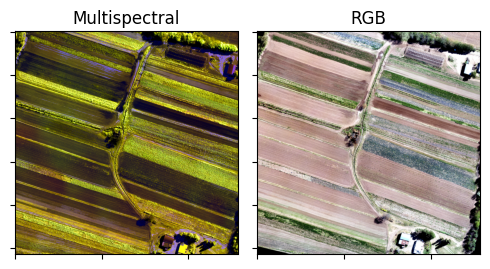

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(5, 10))
axs[0].imshow(image)
axs[0].set_title('Multispectral')

axs[1].imshow(rgb)
axs[1].set_title('RGB')

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

fig.tight_layout()

### Segmentation

In [22]:
def edges_distance_watershed(img, markers, sigma, low, high):
    gray_img = rgb2gray(img)
    if low == 0 and high == 1:
        edges = canny(gray_img, sigma=sigma)
    else:
        edges = canny(gray_img, sigma=sigma, low_threshold=low, high_threshold=high, use_quantiles=True)
    
    expanded = 1 - expand_labels(edges, distance=3)

    distance = ndi.distance_transform_edt(expanded)

    ws = watershed(-distance, markers, mask=expanded)
    regions_plot = label2rgb(watershed(-distance, markers=50, mask=expanded), colors=colors)


    return ws, regions_plot


sigma = 5
markers = 50
low = 0.1
high = 0.9

regions, regions_plot = edges_distance_watershed(image, markers, sigma, low, high)

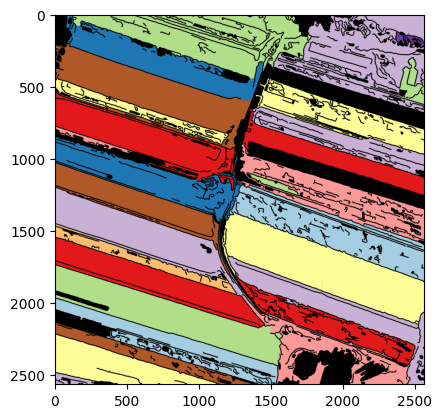

In [23]:
plt.imshow(regions_plot)

### Rotation and cropping

In [48]:
def lines_mean_angle(lines):
    angles = []
    for line in lines:
        p0, p1 = line
        angles.append(np.arctan2(p1[1] - p0[1], p1[0] - p0[0]))

    if len(angles) > 6:
        km = KMeans(3, random_state=0, n_init=10).fit(np.array(angles).reshape(-1, 1))
        counter = Counter(km.labels_)
        most_common_label = max(counter, key=counter.get)
        angles = np.array(angles)[(np.where(km.labels_ == most_common_label))]

    angles = sorted(angles)
    extremes_len = len(angles) // 20
    if len(angles) <= 2 * extremes_len:
        extremes_len = 0
    angles = angles[extremes_len:len(angles)-extremes_len]
    return np.mean(angles)

def get_rotated_and_filled_region_using_probabilistic_hough(region_props, source_image):
    image_bbox = source_image[region_props.bbox[0]:region_props.bbox[2], region_props.bbox[1]:region_props.bbox[3], :]
    region_image = image_bbox.copy()
    region_image[~region_props.image_filled] = [0, 0, 0]

    edges = canny(rgb2gray(region_image), sigma=1)
    lines = probabilistic_hough_line(edges, threshold=1, line_length=int(region_props.major_axis_length * 0.1), line_gap=5)
    angle = 180 + degrees(lines_mean_angle(lines))

    anchor_point = region_props.centroid
    local_anchor_point = region_props.centroid_local
    anchor_mask = np.zeros(shape=(region_image.shape[0], region_image.shape[1]))
    anchor_mask[int(local_anchor_point[0]), int(local_anchor_point[1])] = 1

    rotated = rotate(np.dstack([region_image, anchor_mask]), angle, resize=True)

    region_image = rotated[:, :, :-1]
    anchor_mask = rotated[:, :, -1]
    return region_image, lines, angle, anchor_point, anchor_mask

def get_sobel_values(img, to_gray=True):
    gimg = rgb2gray(img) if to_gray else img
    h = filters.sobel_h(gimg)
    v = filters.sobel_v(gimg)
    sobel_gradient = np.sqrt(h ** 2 + v ** 2)
    sobel_angles = np.arctan2(v, h)
    return sobel_gradient, sobel_angles

def get_active_pixels_crop(src_img, ratio=0.35):
    img = src_img.copy()
    if len(img.shape) == 3:
        img = img[:, :, 2] # NDVI BAND

    active_pixels = (img != 0.0) * 1
    sum_active_pixels = np.sum(active_pixels, axis=1)

    total_row_len = img.shape[1]

    lower_bound, upper_bound = np.where(sum_active_pixels/total_row_len >= ratio)[0][[0, -1]]
    crop = src_img[lower_bound:upper_bound + 1, :]

    sum_active_pixels = np.sum(active_pixels, axis=0)
    total_column_len = img.shape[0]
    left_bound, right_bound = np.where(sum_active_pixels/total_column_len >= 0.05)[0][[0, -1]]
    crop = crop[:, left_bound:right_bound + 1]

    return crop

In [26]:
regions_props = regionprops(regions)

area_threshold = np.mean([rp.area for rp in regions_props]) * 0.25

# Only keep regions with area bigger than the threshold
big_regions = [rp for rp in regions_props if rp.area > area_threshold]

In [51]:
rotated_regions = []
for rp in big_regions:
    region_image, lines, angle, anchor, anchor_mask = get_rotated_and_filled_region_using_probabilistic_hough(rp, image)
    
    highlight = rgb.copy()
    
    highlight = np.dstack([highlight, np.where(regions == rp.label, 1, 0.20)])
    
    base_img = np.zeros_like(image[rp.bbox[0]:rp.bbox[2], rp.bbox[1]:rp.bbox[3], :])
    base_img[rp.image_filled] = image[rp.bbox[0]:rp.bbox[2], rp.bbox[1]:rp.bbox[3], :][rp.image_filled]

    cropped = get_active_pixels_crop(region_image)
    
    rotated_regions.append(
        {
            "rotated": region_image,
            "original": base_img,
            "highlight": highlight,
            "lines": lines,
            "cropped": cropped,
        }
    )

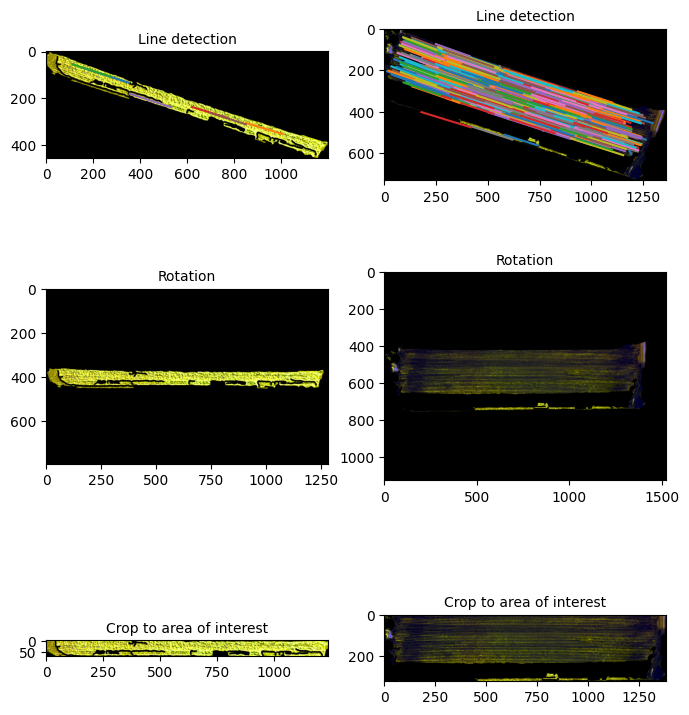

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))

idx1 = 2
idx2 = 3

r1 = rotated_regions[idx1]['rotated']
r2 = rotated_regions[idx2]['rotated']

b1 = rotated_regions[idx1]['original']
b2 = rotated_regions[idx2]['original']

l1 = rotated_regions[idx1]['lines']
l2 = rotated_regions[idx2]['lines']

c1 = rotated_regions[idx1]['cropped']
c2 = rotated_regions[idx2]['cropped']

axes[0, 0].imshow(b1)
axes[0, 1].imshow(b2)

for line in l1:
    p0, p1 = line
    axes[0, 0].plot((p1[0], p0[0]), (p1[1], p0[1]))
axes[0, 0].title.set_text('Line detection')
axes[0, 0].title.set_fontsize(10)

for line in l2:
    p0, p1 = line
    axes[0, 1].plot((p1[0], p0[0]), (p1[1], p0[1]))

axes[0, 1].title.set_text('Line detection')
axes[0, 1].title.set_fontsize(10)

axes[1, 0].imshow(r1)
axes[1, 1].imshow(r2)

axes[1, 0].title.set_text('Rotation')
axes[1, 0].title.set_fontsize(10)

axes[1, 1].title.set_text('Rotation')
axes[1, 1].title.set_fontsize(10)

axes[2, 0].imshow(c1)
axes[2, 1].imshow(c2)

axes[2, 0].title.set_text('Crop to area of interest')
axes[2, 0].title.set_fontsize(10)
axes[2, 1].title.set_text('Crop to area of interest')
axes[2, 1].title.set_fontsize(10)

### Crop Row Identification

In [65]:
def get_img_with_lines(img):
    sum_cols_r = np.sum(gaussian(img[..., 2]), axis=1) 
    peaks = find_peaks(sum_cols_r, width=2)[0]
    img_1 = img.copy()
    img_1[peaks, :] = (1, 0, 0)
    return img_1

In [77]:
region1 = get_img_with_lines(rotated_regions[3]['cropped'])
region2 = get_img_with_lines(rotated_regions[8]['cropped'])

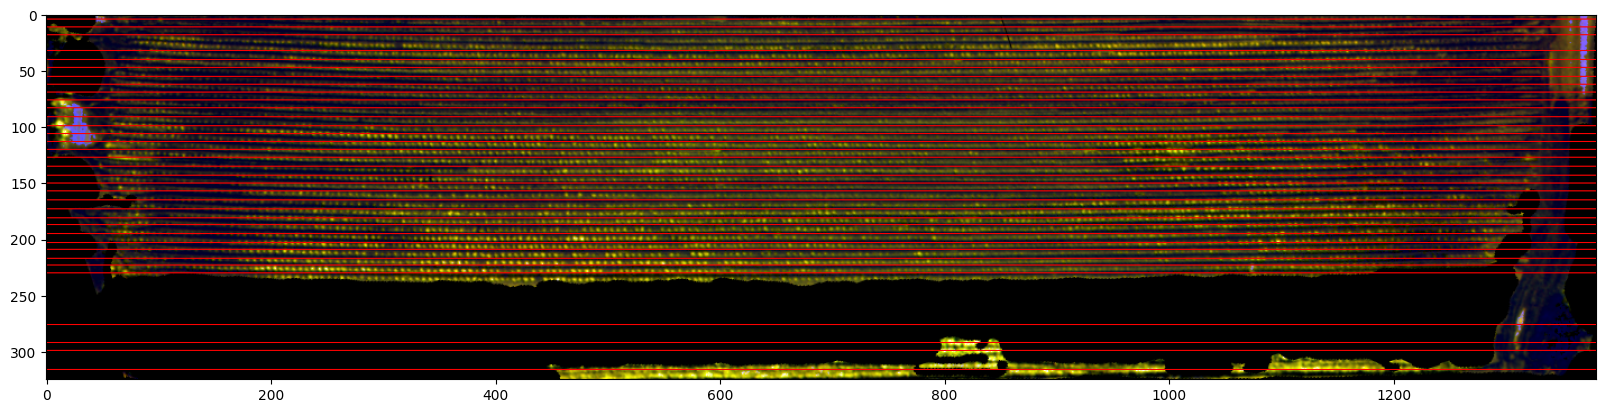

In [79]:
plt.figure(figsize=(20, 20))
plt.imshow(region1)

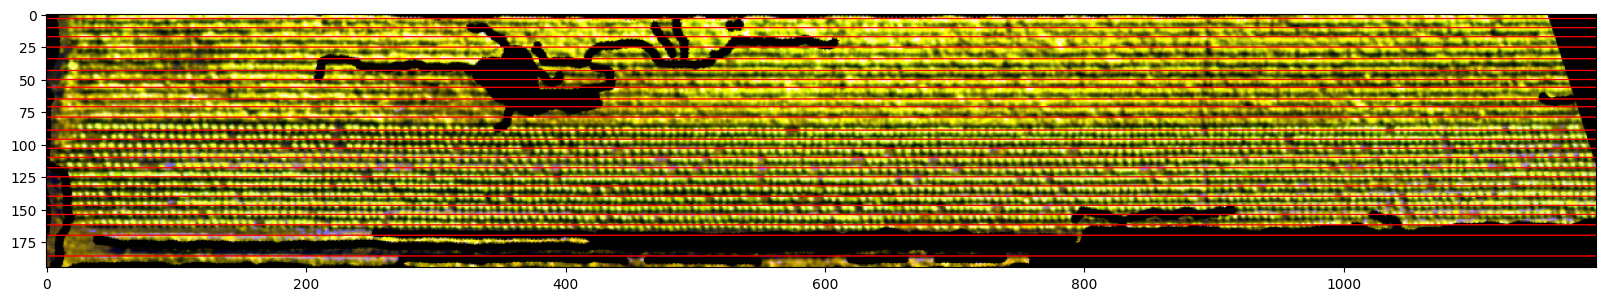

In [78]:
plt.figure(figsize=(20, 20))
plt.imshow(region2)